# Chap 09. Diffusion 0.1

----

Conda env : [cv_playgrounds](../../README.md#setup-a-conda-environment)

----

In [18]:
# @title 9.0 Detect device
import torch

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)


mps


In [22]:
# @title 9.1.2 Simple U-Net

import torch
import torch.nn as nn

class SConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding = 1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding = 1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )
    def forward(self, x):
        return self.convs(x)

class SUNet(nn.Module):
    def __init__(self, in_ch = 1):
        super().__init__()

        self.down1 = SConvBlock(in_ch, 64)
        self.down2 = SConvBlock(64, 128)
        self.bot1 = SConvBlock(128, 256)
        self.up2 = SConvBlock(256 + 128, 128)
        self.up1 = SConvBlock(128 + 64, 64)
        self.out = nn.Conv2d(64, in_ch, 1)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')

    def forward(self, x):
        x1 = self.down1(x)
        x = self.maxpool(x1)
        x2 = self.down2(x)
        x = self.maxpool(x2)

        x = self.bot1(x)

        x = self.upsample(x)
        x = torch.cat([x, x2], dim = 1)
        x = self.up2(x)

        x = self.upsample(x)
        x = torch.cat([x, x1], dim= 1)
        x = self.up1(x)

        x = self.out(x)

        return x


model = SUNet()
x = torch.randn(10, 1, 28, 28)
y = model(x)
print(f"Input : {x.shape}")
print(f"Output : {y.shape}")


Input : torch.Size([10, 1, 28, 28])
Output : torch.Size([10, 1, 28, 28])


## Positional encoding :
- $v_i = sin\big( \frac{t}{10000^{1/D}} \big), i == even$
- $v_i = cos\big( \frac{t}{10000^{1/D}} \big), i == odd$

In [23]:
# @title 9.2.2 Positional encoding
# @markdown $1$

import torch

def _pos_encoding(t, output_dim, device='cpu'):
    D = output_dim
    v = torch.zeros(D, device = device)

    i = torch.arange(0, D, device = device)
    div_term = 10000 ** (i/D)

    v[0::2] = torch.sin(t / div_term[0::2])
    v[1::2] = torch.cos(t / div_term[1::2])

    return v

v = _pos_encoding(1, 16)
print(v.shape)

def pos_encoding(ts, output_dim, device='cpu'):
    batch_size = len(ts)
    v = torch.zeros(batch_size, output_dim, device=device)
    for i in range(batch_size):
        v[i] = _pos_encoding(ts[i], output_dim, device)
    return v


v = pos_encoding(torch.tensor([1, 2, 3]), 16)
print(v.shape)

torch.Size([16])
torch.Size([3, 16])


In [24]:
# @title 9.2.3 U-Net with position encoding

import torch
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_embed_dim):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding = 1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding = 1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )

        self.mlp = nn.Sequential(
            nn.Linear(time_embed_dim, in_ch),
            nn.ReLU(),
            nn.Linear(in_ch, in_ch)
        )

    def forward(self, x, v):
        N, C, _, _ = x.shape
        v = self.mlp(v)
        v = v.view(N, C, 1, 1)
        y = self.convs(x + v)
        return y

class UNet(nn.Module):
    def __init__(self, in_ch = 1, time_embed_dim = 100):
        super().__init__()

        self.time_embed_dim = time_embed_dim
        self.down1 = ConvBlock(in_ch, 64, time_embed_dim)
        self.down2 = ConvBlock(64, 128, time_embed_dim)
        self.bot1 = ConvBlock(128, 256, time_embed_dim)
        self.up2 = ConvBlock(256 + 128, 128, time_embed_dim)
        self.up1 = ConvBlock(128 + 64, 64, time_embed_dim)
        self.out = nn.Conv2d(64, in_ch, 1)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')

    def forward(self, x, timesteps):
        v = pos_encoding(timesteps, self.time_embed_dim, x.device)

        x1 = self.down1(x, v)
        x = self.maxpool(x1)
        x2 = self.down2(x, v)
        x = self.maxpool(x2)

        x = self.bot1(x, v)

        x = self.upsample(x)
        x = torch.cat([x, x2], dim = 1)
        x = self.up2(x, v)

        x = self.upsample(x)
        x = torch.cat([x, x1], dim= 1)
        x = self.up1(x, v)

        x = self.out(x)

        return x


model = UNet(time_embed_dim=10)
x = torch.randn(10, 1, 28, 28)
v = torch.randn(10)

y = model(x, v)
print((y.shape))

torch.Size([10, 1, 28, 28])


In [ ]:
# @title 9.3.1 Saming with q(x_t|x_{x-1})

import torch

x = torch.randn(3, 64, 64)
T = 1000
betas = torch.linspace(0.0001, 0.02, T)

for t in range(T):
    beta = betas[t]
    eps = torch.randn_like(x)
    x = torch.sqrt(1 - beta) * x + torch.sqrt(beta) * eps


(64, 64, 3)
torch.Size([3, 64, 64])


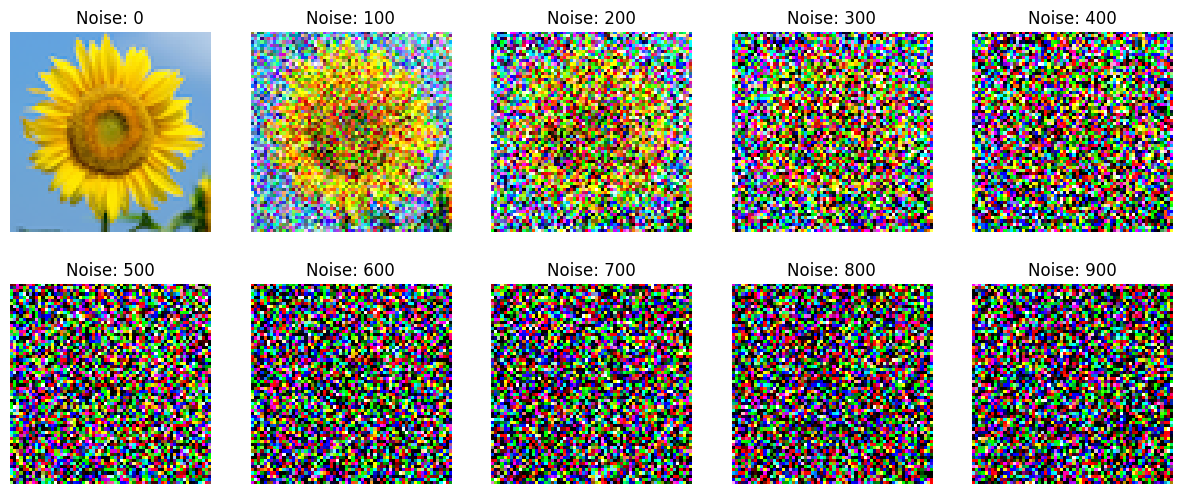

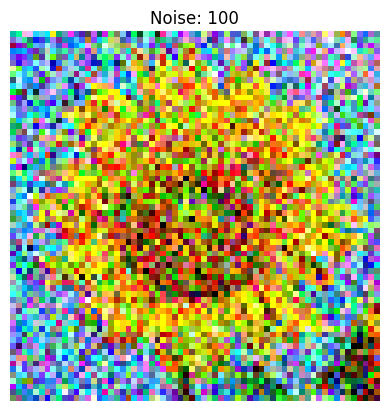

In [25]:
# @title 9.3.2 - 9.3.3 Image diffusion
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms


if not os.path.exists('flower.png'):
    !wget https://raw.githubusercontent.com/oreilly-japan/deep-learning-from-scratch-5/main/step09/flower.png

# load image
file_path = 'flower.png'
image = plt.imread(file_path)
print(image.shape)  # (64, 64, 3)

# preprocess
preprocess = transforms.ToTensor()
x = preprocess(image)
print(x.shape)  # (3, 64, 64)

original_x = x.clone()  # keep original image

def reverse_to_img(x):
    x = x * 255
    x = x.clamp(0, 255)
    x = x.to(torch.uint8)
    to_pil = transforms.ToPILImage()
    return to_pil(x)

T = 1000
beta_start = 0.0001
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, T)
imgs = []

# ============================================
# q(x_t|x_t-1)
# ============================================
for t in range(T):
    if t % 100 == 0:
        img = reverse_to_img(x)
        imgs.append(img)

    beta = betas[t]
    eps = torch.randn_like(x)
    x = torch.sqrt(1 - beta) * x + torch.sqrt(beta) * eps

# show imgs
plt.figure(figsize=(15, 6))
for i, img in enumerate(imgs[:10]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f'Noise: {i * 100}')
    plt.axis('off')
plt.show()



# ============================================
# q(x_t|x_0)
# ============================================
def add_noise(x_0, t, betas):
    T = len(betas)
    assert t >= 1 and t <= T
    t_idx = t - 1  # betas[0] is for t=1

    alphas = 1 - betas
    alpha_bars = torch.cumprod(alphas, dim=0)
    alpha_bar = alpha_bars[t_idx]

    eps = torch.randn_like(x_0)
    x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * eps
    return x_t

x = original_x

t = 100
x_t = add_noise(x, t, betas)

img = reverse_to_img(x_t)
plt.imshow(img)
plt.title(f'Noise: {t}')
plt.axis('off')
plt.show()

### 9.4 Diffusion 

In [7]:
## @title 9.3-9.4 Diffusion

import math
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn.functional as F
from torch import nn
from tqdm import tqdm
import numpy as np

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


def show_images(images, rows=2, cols=10):
    def last_argmin(arr):
        arr_rev = arr[::-1]
        return len(arr_rev) - 1 - np.argmin(arr_rev)

    img_num = len(images)

    col_set = [2, 3, 5]
    x = [img_num % i for i in col_set]
    cols = col_set[last_argmin(x)]
    rows = math.ceil(img_num / cols)

    fig = plt.figure(figsize=(cols, rows))
    # i = 0
    # for r in range(rows):
    #     for c in range(cols):
    #         fig.add_subplot(rows, cols, i + 1)
    #         plt.imshow(images[i], cmap='gray')
    #         plt.axis('off')
    #         i += 1
    for i in range(img_num):
        fig.add_subplot(rows, cols, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')
    plt.show()

def _pos_encoding(time_idx, output_dim, device='cpu'):
    t, D = time_idx, output_dim
    v = torch.zeros(D, device=device)

    i = torch.arange(0, D, device=device)
    div_term = torch.exp(i / D * math.log(10000))

    v[0::2] = torch.sin(t / div_term[0::2])
    v[1::2] = torch.cos(t / div_term[1::2])
    return v

def pos_encoding(timesteps, output_dim, device='cpu'):
    batch_size = len(timesteps)
    device = timesteps.device
    v = torch.zeros(batch_size, output_dim, device=device)
    for i in range(batch_size):
        v[i] = _pos_encoding(timesteps[i], output_dim, device)
    return v

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_embed_dim):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )
        self.mlp = nn.Sequential(
            nn.Linear(time_embed_dim, in_ch),
            nn.ReLU(),
            nn.Linear(in_ch, in_ch)
        )

    def forward(self, x, v):
        N, C, _, _ = x.shape
        v = self.mlp(v)
        v = v.view(N, C, 1, 1)
        y = self.convs(x + v)
        return y

class UNet(nn.Module):
    def __init__(self, in_ch=1, time_embed_dim=100):
        super().__init__()
        self.time_embed_dim = time_embed_dim

        self.down1 = ConvBlock(in_ch, 64, time_embed_dim)
        self.down2 = ConvBlock(64, 128, time_embed_dim)
        self.bot1 = ConvBlock(128, 256, time_embed_dim)
        self.up2 = ConvBlock(128 + 256, 128, time_embed_dim)
        self.up1 = ConvBlock(128 + 64, 64, time_embed_dim)
        self.out = nn.Conv2d(64, in_ch, 1)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')

    def forward(self, x, timesteps):
        v = pos_encoding(timesteps, self.time_embed_dim, x.device)

        x1 = self.down1(x, v)
        x = self.maxpool(x1)
        x2 = self.down2(x, v)
        x = self.maxpool(x2)

        x = self.bot1(x, v)

        x = self.upsample(x)
        x = torch.cat([x, x2], dim=1)
        x = self.up2(x, v)
        x = self.upsample(x)
        x = torch.cat([x, x1], dim=1)
        x = self.up1(x, v)
        x = self.out(x)
        return x


class Diffuser:
    def __init__(self, num_timesteps=1000, beta_start=0.0001, beta_end=0.02, device='cpu'):
        self.num_timesteps = num_timesteps
        self.device = device
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, device=device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

    def add_noise(self, x_0, t):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()

        t_idx = t - 1  # alpha_bars[0] is for t=1
        alpha_bar = self.alpha_bars[t_idx]  # (N,)
        N = alpha_bar.size(0)
        alpha_bar = alpha_bar.view(N, 1, 1, 1)  # (N, 1, 1, 1)

        noise = torch.randn_like(x_0, device=self.device)
        x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * noise
        return x_t, noise

    def denoise(self, model, x, t , device = None):
        if device is None:
            device = self.device

        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()

        t_idx = t - 1  # alphas[0] is for t=1
        alpha = self.alphas[t_idx]
        alpha_bar = self.alpha_bars[t_idx]
        alpha_bar_prev = self.alpha_bars[t_idx-1]

        N = alpha.size(0)
        alpha = alpha.view(N, 1, 1, 1)
        alpha_bar = alpha_bar.view(N, 1, 1, 1)
        alpha_bar_prev = alpha_bar_prev.view(N, 1, 1, 1)

        model.eval()
        with torch.no_grad():
            eps = model(x, t)
        model.train()

        noise = torch.randn_like(x, device = device)
        noise[t == 1] = 0  # no noise at t=1

        mu = (x - ((1-alpha) / torch.sqrt(1-alpha_bar)) * eps) / torch.sqrt(alpha)
        std = torch.sqrt((1-alpha) * (1-alpha_bar_prev) / (1-alpha_bar))
        return mu + noise * std

    def reverse_to_img(self, x):
        x = x * 255
        x = x.clamp(0, 255)
        x = x.to(torch.uint8)
        x = x.cpu()
        to_pil = transforms.ToPILImage()
        return to_pil(x)

    def sample(self, model = None, x_shape=(20, 1, 28, 28), step = 1):
        if model is None:
            model = self.model

        device_ = next(model.parameters()).device
        batch_size = x_shape[0]
        x = torch.randn(x_shape, device = device_)

        t_range = list(range(self.num_timesteps, 0, -step)) + [1]
        t_range = sorted(list(set(t_range)), reverse=True)


        for i in tqdm(t_range):
            t = torch.tensor([i] * batch_size, device = device_, dtype=torch.long)
            x = self.denoise(model, x, t, device = device_)

        images = [self.reverse_to_img(x[i]) for i in range(batch_size)]
        return images


100%|██████████| 469/469 [00:36<00:00, 12.74it/s]


Epoch 0 | Loss: 0.04557151094809778


100%|██████████| 469/469 [00:36<00:00, 12.80it/s]


Epoch 1 | Loss: 0.026104560761309382


100%|██████████| 469/469 [00:36<00:00, 12.84it/s]


Epoch 2 | Loss: 0.023042469366844783


100%|██████████| 469/469 [00:36<00:00, 12.82it/s]


Epoch 3 | Loss: 0.021279404853293892


100%|██████████| 469/469 [00:36<00:00, 12.82it/s]


Epoch 4 | Loss: 0.020516498171206096


100%|██████████| 469/469 [00:36<00:00, 12.76it/s]


Epoch 5 | Loss: 0.01984142160205953


100%|██████████| 469/469 [00:36<00:00, 12.83it/s]


Epoch 6 | Loss: 0.018772631720788698


100%|██████████| 469/469 [00:36<00:00, 12.84it/s]


Epoch 7 | Loss: 0.018280818029793342


100%|██████████| 469/469 [00:36<00:00, 12.79it/s]


Epoch 8 | Loss: 0.018005685745748377


100%|██████████| 469/469 [00:36<00:00, 12.83it/s]

Epoch 9 | Loss: 0.01801675365868408


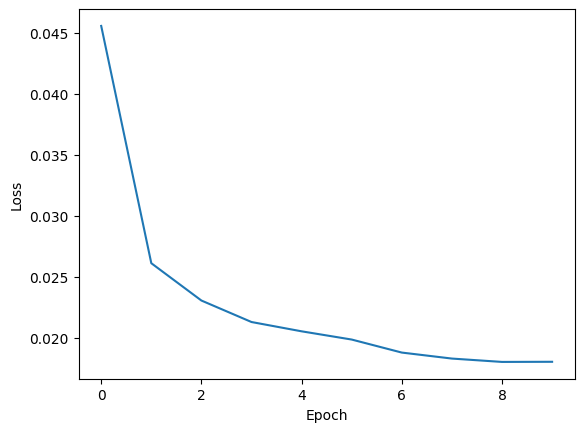

100%|██████████| 1000/1000 [00:11<00:00, 90.41it/s]


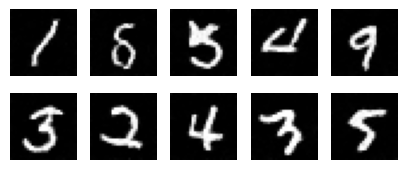

In [8]:
# @title 9.4 - 9.5 Training Loop

class Diffuser_Trainer:
    def __init__(self,
                 num_timesteps = 1000, beta_start=0.0001, beta_end=0.02, # parameters for Diffuser
                 img_shape = (1, 28, 28), time_embed_dim = 100,          # parameters for UNet
                 device = 'cpu'):                                        # common parameters

        self.num_timesteps = num_timesteps
        self.img_shape = img_shape
        self.device = device
        self.diffuser = Diffuser(num_timesteps, beta_start, beta_end, device=self.device)
        self.model = UNet(in_ch=img_shape[0], time_embed_dim = time_embed_dim)
        self.model.to(self.device)

    def train(self,
              dataset, batch_size = 128, epochs = 10, lr = 1e-3 ): # paramters for training

        optimizer = Adam(self.model.parameters(), lr=lr)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        losses = []
        for epoch in range(epochs):
            loss_sum = 0.0
            cnt = 0

            # generate samples every epoch ===================
            # images = diffuser.sample(model)
            # show_images(images)
            # ================================================

            for images, labels in tqdm(dataloader):
                optimizer.zero_grad()
                x = images.to(self.device)
                t = torch.randint(1, self.num_timesteps+1, (len(x),), device=self.device)

                x_noisy, noise = self.diffuser.add_noise(x, t)
                noise_pred = self.model(x_noisy, t)
                loss = F.mse_loss(noise, noise_pred)

                loss.backward()
                optimizer.step()

                loss_sum += loss.item()
                cnt += 1

            loss_avg = loss_sum / cnt
            losses.append(loss_avg)
            print(f'Epoch {epoch} | Loss: {loss_avg}')

        # plot losses
        plt.plot(losses)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()

        # generate samples
        img_shape = [10] + list(self.img_shape)
        images = self.diffuser.sample(self.model, x_shape = img_shape)
        show_images(images)


preprocess = transforms.ToTensor()
mnist_dataset = torchvision.datasets.MNIST(root='./data', download=True, transform=preprocess)


mnist_trainer = Diffuser_Trainer(device=device)
mnist_trainer.train(mnist_dataset)



100%|██████████| 1000/1000 [00:20<00:00, 49.57it/s]


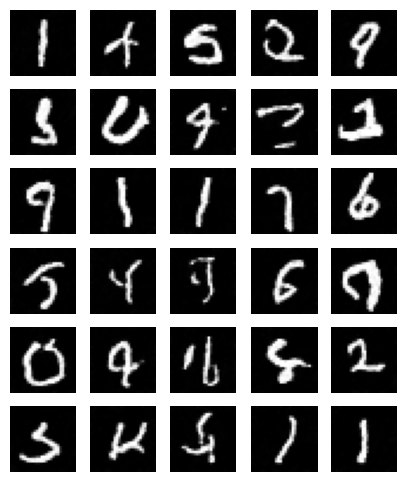

In [9]:
img_shape = [30] + list(mnist_trainer.img_shape)
images = mnist_trainer.diffuser.sample(mnist_trainer.model, x_shape = img_shape)
show_images(images)


torch.Size([3, 256, 256])


100%|██████████| 8/8 [16:16<00:00, 122.10s/it]


Epoch 0 | Loss: 0.6237912587821484


100%|██████████| 8/8 [32:58<00:00, 247.30s/it]


Epoch 1 | Loss: 0.23696105368435383


100%|██████████| 8/8 [27:14<00:00, 204.36s/it]


Epoch 2 | Loss: 0.17261064611375332


100%|██████████| 8/8 [32:00<00:00, 240.12s/it]


Epoch 3 | Loss: 0.14134343154728413


100%|██████████| 8/8 [35:21<00:00, 265.16s/it]


Epoch 4 | Loss: 0.12150844652205706


100%|██████████| 8/8 [34:00<00:00, 255.12s/it]


Epoch 5 | Loss: 0.10321298521012068


100%|██████████| 8/8 [26:19<00:00, 197.49s/it]


Epoch 6 | Loss: 0.09890106320381165


100%|██████████| 8/8 [41:21<00:00, 310.17s/it]


Epoch 7 | Loss: 0.08277525566518307


100%|██████████| 8/8 [32:43<00:00, 245.45s/it]


Epoch 8 | Loss: 0.08369391970336437


100%|██████████| 8/8 [31:41<00:00, 237.63s/it]


Epoch 9 | Loss: 0.07696187682449818


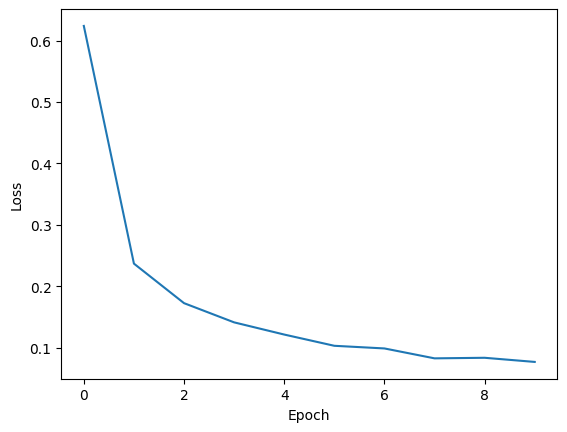

100%|██████████| 1000/1000 [02:20<00:00,  7.09it/s]


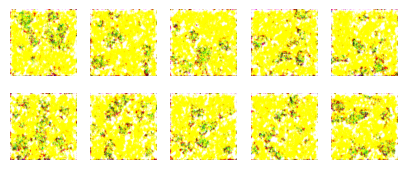

In [10]:
# preprocess = transforms.ToTensor()
preprocess = transforms.Compose([
    transforms.Resize(256),  # Resize the image to 256x256
    transforms.CenterCrop(256), # Crop the center 224x224 region
    transforms.ToTensor() # Convert the image to a tensor
])
flower_dataset = torchvision.datasets.Flowers102(root='./data', download=True, transform=preprocess)
print(flower_dataset[0][0].shape)
img_shape = flower_dataset[0][0].shape

flower_trainer = Diffuser_Trainer(img_shape = img_shape, device = device)
flower_trainer.train(flower_dataset)

100%|██████████| 1000/1000 [3:38:42<00:00, 13.12s/it] 


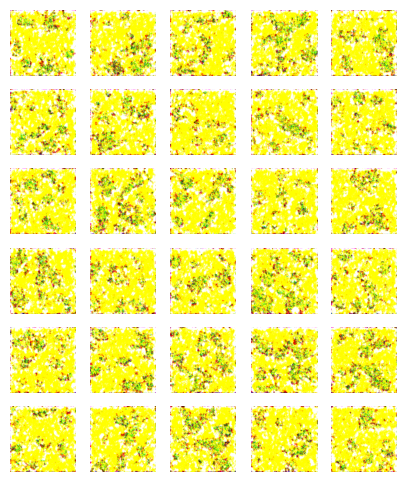

In [11]:
def show_images(images, rows=2, cols=10):
    def last_argmin(arr):
        arr_rev = arr[::-1]
        return len(arr_rev) - 1 - np.argmin(arr_rev)

    img_num = len(images)

    col_set = [2, 3, 5]
    x = [img_num % i for i in col_set]
    cols = col_set[last_argmin(x)]
    rows = math.ceil(img_num / cols)

    fig = plt.figure(figsize=(cols, rows))
    # i = 0
    # for r in range(rows):
    #     for c in range(cols):
    #         fig.add_subplot(rows, cols, i + 1)
    #         plt.imshow(images[i], cmap='gray')
    #         plt.axis('off')
    #         i += 1
    for i in range(img_num):
        fig.add_subplot(rows, cols, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.show()

img_shape = [30] + list(flower_trainer.img_shape)
images = flower_trainer.diffuser.sample(flower_trainer.model, x_shape = img_shape)
show_images(images)

torch.Size([3, 256, 256])


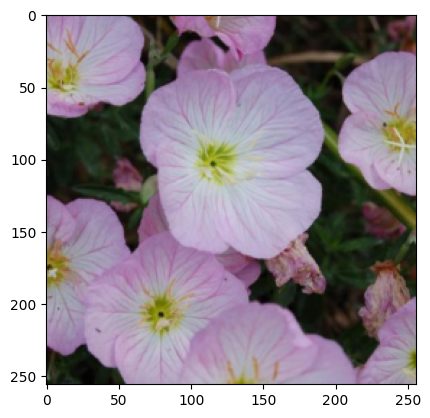

In [18]:
img_t = flower_dataset[0][0]
print(img_t.shape)
# images = [self.reverse_to_img(x[i]) for i in range(batch_size)]
t_pil = transforms.ToPILImage()
img = t_pil(img_t)
plt.imshow(img)
plt.show()

100%|██████████| 1000/1000 [00:41<00:00, 23.85it/s]


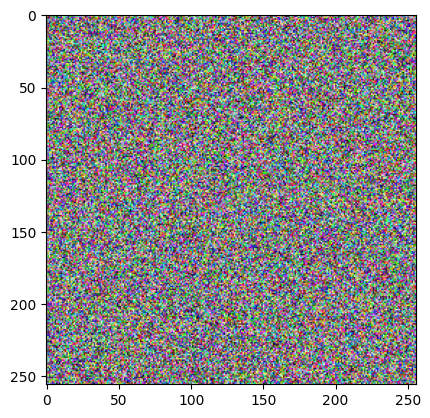

In [29]:
x = torch.randn([2, 3, 256, 256], device = device)

t_range = list(range(flower_trainer.diffuser.num_timesteps, 0, -1)) + [1]
t_range = sorted(list(set(t_range)), reverse=True)

for i in tqdm(t_range):
    t = torch.tensor([i] * 2, device = device, dtype=torch.long)
    x = flower_trainer.diffuser.denoise(flower_trainer.model, x, t, device = device)

img_t_1 = x[1]
img_1 = t_pil(img_t_1)
plt.imshow(img_1)
plt.show()


In [78]:
def last_argmin(arr):
    arr_rev = arr[::-1]
    return len(arr_rev) - 1 - np.argmin(arr_rev)

img_num = 20

col_set = [2, 3, 5]
x = [img_num % i for i in col_set]
print(x)
cols = col_set[last_argmin(x)]
rows = math.ceil(img_num / cols)
print(cols, rows)



[0, 2, 0]
5 4
